In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

import matplotlib.pyplot as plt

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from utils_local.misc import amro2title, amro2cute
import matplotlib.ticker as mtick


In [2]:
def empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv"):
    amro_prev_df = pd.read_csv(path_to_prev)
    gammas       = amro_prev_df[amro_prev_df.amro==amro][["prevalence_mean1", "prevalence_mean2", "prevalence_mean3"]].values / 100
    return np.squeeze(gammas)

def simulate_abm(f, f0, g, θ, model_settings):
    dates_simulation = model_settings["dates_simulation"]

    x                     = f0(θ)
    observations          = np.full((len(dates_simulation), model_settings["k"], model_settings["m"]), np.nan)
    observations[0, :, :] = g(0, x, θ)

    for t, date in enumerate(dates_simulation[1:]):
        x                       = f(t, x, θ)
        observations[t+1, :, :] = g(t, x, θ)
    return observations

def create_obs_infer(obs_sim, idx_infer, dates, model_settings, resample="W-Sun"):
    # obs_sim \in R^{[k x T x m]} as required by pompjax
    infer_df = pd.DataFrame(index=dates)
    for i in range(model_settings["k"]) :
        infer_df['y'+str(i+1)]   = obs_sim[i, :, idx_infer]
        infer_df['oev'+str(i+1)] = 1 +(0.2 * infer_df['y'+str(i+1)].values)**2
    infer_df                     = infer_df.resample(resample).sum()
    infer_df.index.values[-1]    = model_settings["dates"][-1]
    return infer_df

In [3]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
ward2buildingid        =  {row.ward: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_83186/2265996033.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [4]:
from models import amr_abm, observe_cluster_individual

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0


In [6]:
from data_utils import create_obs_building_amro
from infer_utils import run_amro_inference

amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_amro = os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" )

In [ ]:

for amro in amro_search:
    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")
    os.makedirs(os.path.join(results2_dir, "amro_inferences", "abm"), exist_ok=True)

    gammas        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    if_settings["adjust_state_space"] = False
    if_settings["shrink_variance"]    = False

    for idx_gamma, gamma in enumerate(gammas):

        path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
        inference       = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))


In [27]:
amro   = amro_search[0]
gammas = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")
obs_df = create_obs_building_amro(amro, model_settings, ward2buildingid, path_to_amro)

path_to_save    = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")

idx_gamma       = 0
gamma           = gammas[0]
path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
inference       = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

alpha = 1/120
f0    = lambda θ:       amr_abm(t = 0,
                                                agents_state   = np.zeros((model_settings["n"], model_settings["m"])),
                                                gamma          = gamma,
                                                beta           = θ[1, :],
                                                alpha          = alpha,
                                                movement       = movement_df[movement_df["date"]==dates_simulation[0]],
                                                ward2size      = ward2size,
                                                model_settings = model_settings)
f       = lambda t, x, θ: amr_abm(t = t,
                                                agents_state   = x,
                                                gamma          = gamma,
                                                beta           = θ[1, :],
                                                alpha          = alpha,
                                                movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                ward2size      = ward2size,
                                                model_settings = model_settings)
g = lambda t, x, θ: observe_cluster_individual(t = t,
                                                agents_state   = x,
                                                rho            = θ[0, :],
                                                movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                model_settings = model_settings)

θ    = inference["posterior"].mean(-2)[:, :, -1]
ysim = simulate_abm(f, f0, g, θ, model_settings)

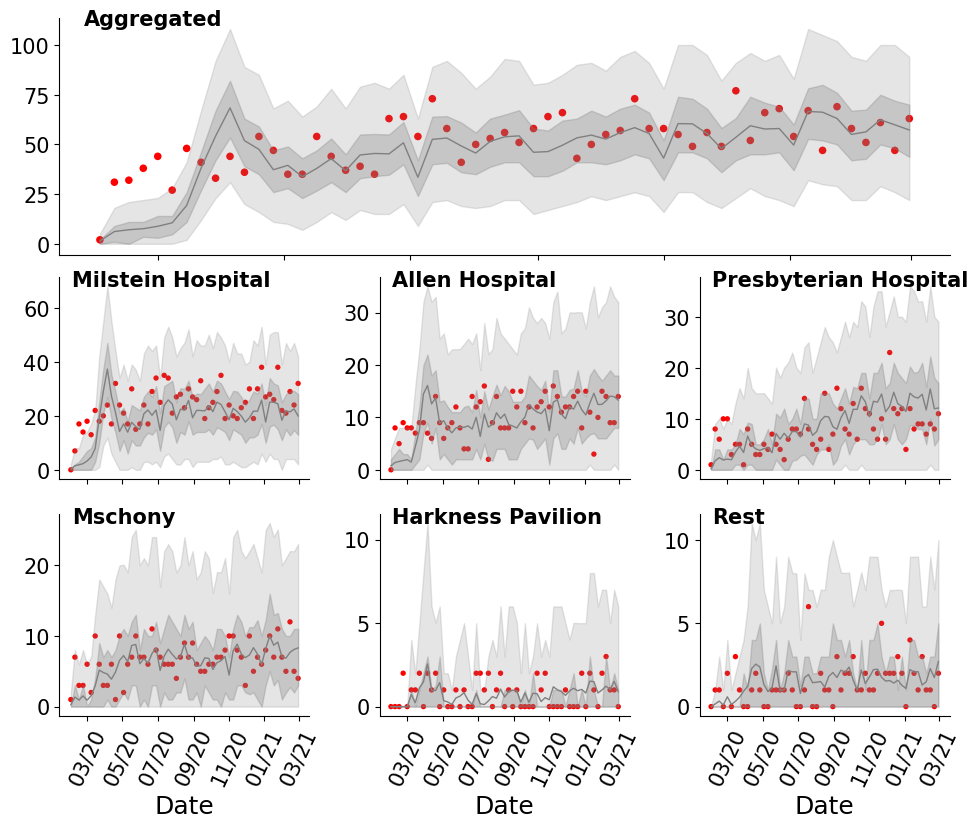

In [156]:
from matplotlib import dates as mdates
from utils import create_df_response
from utils_local import plot_utils


def format_axis(ax, week=False):
    ax.tick_params(which='both', axis='x', labelrotation=90)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    if week:
        ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

id2building    = {v: k for k, v in building2id.items()}
id2building[5] = "Rest"

fig     = plt.figure(constrained_layout=True, figsize=(10.5, 7.2))
subfigs = fig.subfigures(2, 1, hspace=0.1, wspace=0.2, height_ratios=[0.35, 0.65])

# hospital level
ax1      = subfigs[0].subplots(1, 1, sharex="col")

yi_df = create_df_response(ysim[:, :, :].sum(1), time=len(model_settings["dates_simulation"]), dates=model_settings["dates_simulation"])
yi_df = yi_df.drop(columns=["type"]).resample("W-Sun").sum()

ax1.scatter(if_settings["assimilation_dates"], obs_df[[f"y{i+1}" for i in range(model_settings["k"])]].sum(axis=1),
                ec=None, fc="red", label="Data", s=30)

ax1.plot(yi_df.index, yi_df["mean"], label="Median", color="gray", lw=1)
ax1.fill_between(yi_df.index, yi_df["low_95"], yi_df["high_95"], color="gray", alpha=0.2, label="95% CI")
ax1.fill_between(yi_df.index, yi_df["low_50"], yi_df["high_50"], color="gray", alpha=0.3, label="50% CI")

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend().remove()
ax1.set_ylabel(None)

ax1.tick_params(which='both', axis='x', labelrotation=0)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax1.text(x = 18286.0, y = 110, s="Aggregated", fontweight = "bold")

# building level
ax2      = subfigs[1].subplots(2, 3, sharex=True, sharey=False)
pos2plot = {0:2, 1: 0, 2: 4, 3: 3, 4: 1, 5: 5}

for idx_axi, axi, in enumerate(ax2.flatten()):
    idx_axi = pos2plot[idx_axi]

    yi_df = create_df_response(ysim[:, idx_axi, :], time=len(model_settings["dates_simulation"]), dates=model_settings["dates_simulation"])
    yi_df = yi_df.drop(columns=["type"]).resample("W-Sun").sum()

    axi.scatter(if_settings["assimilation_dates"], obs_df[f"y{idx_axi+1}"],
                        ec=None, fc="red", label="Data", s=15)
    axi.plot(yi_df.index, yi_df["mean"], label="Mean", color="gray", lw=1)
    axi.fill_between(yi_df.index, yi_df["low_95"], yi_df["high_95"], color="gray", alpha=0.2, label="95% CI")
    axi.fill_between(yi_df.index, yi_df["low_50"], yi_df["high_50"], color="gray", alpha=0.3, label="50% CI")

    axi.tick_params(which='both', axis='x', labelrotation=65)
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.legend().remove()
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    axi.text(x = 18296.0, y = yi_df["high_95"].max(),
                s=id2building[idx_axi].split("-")[0], fontweight = "bold")

#ax2[0, 0].legend(loc="upper left", bbox_to_anchor=(0.0, 1.25), ncol=4, frameon=False)
for i in range(3):
    ax2[-1, i].set_xlabel("Date")

plt.tight_layout()
